## Gradient Boosting Classifier
This notebook defines the python script corresponding to the non-DL scenario. The multinomial classifier I used is the **XGB** implementation which supports the GPU acceleration

In [3]:
# load training set
import pandas as pd
import numpy as np

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('c:/Users/I051796/Projects/CES/data/label.csv', sep=';')

##  Data Preparation

In [4]:
# vectorize the text with TF-IDF transform
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

vectorizer = TfidfVectorizer(strip_accents='ascii')
XTFIDFVectorizedTrain = vectorizer.fit_transform(XTrain['question'])
XTFIDFVectorizedTrain = pd.DataFrame(XTFIDFVectorizedTrain.toarray())
XTFIDFVectorizedTrain.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8088,8089,8090,8091,8092,8093,8094,8095,8096,8097
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# perform a dimensional reduction into 600 dimensional space
# use the same dimensionality than the one provided by fasttext embedding model in the DL context
from sklearn.decomposition import PCA

PCATransform = PCA(n_components=600)
PCAXTrain = pd.DataFrame(PCATransform.fit_transform(XTFIDFVectorizedTrain))

In [6]:
from sklearn.model_selection import train_test_split
# combine input features from above text vectorization with text characteristics features (../../data/staging_data/text_extracted_features.csv)
extractedFeatures = pd.read_csv('../../data/staging_data/text_extracted_features.csv', sep=',')
mergedXTrain = PCAXTrain.join(extractedFeatures, lsuffix='', rsuffix='')

# split into train and test
mergedXTrain, mergedXTest, YTrain, YTest = train_test_split(mergedXTrain, YTrain, test_size=0.15, random_state=42)

mergedXTrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,quandCount,quoiCount,commentCount,avecCount,etCount,ouCount,interrogativeIndex,interrogativeWordIndex,drugWordIndex,drugInterrogativeDistance
1188,-0.022080,0.115306,-0.052684,-0.018243,0.013611,0.045028,0.021544,0.007577,-0.045304,0.126469,...,0,0,0,0,0,0,NaN,NaN,0.0,NaN
4252,-0.036458,-0.093671,0.078570,0.011583,-0.005970,-0.042887,-0.061000,-0.042579,0.012347,0.080052,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
447,0.002183,-0.058091,-0.061282,0.031988,-0.051414,-0.031547,-0.014163,0.001244,-0.063170,0.010844,...,0,0,0,0,0,0,NaN,NaN,0.0,NaN
2926,-0.033489,0.044952,-0.015442,-0.042209,-0.025078,-0.004677,0.013900,-0.051662,-0.022536,-0.112461,...,0,0,0,0,0,0,NaN,NaN,0.0,NaN
3733,0.026777,-0.040575,-0.017606,-0.033485,-0.016522,-0.012776,-0.040642,0.087152,-0.069953,-0.036054,...,0,0,0,0,0,0,NaN,NaN,3.0,NaN


## Hyper-parameter Search

In [11]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# run a grid search with key parameter value candidates
# max_depth
# min_child_weight
# n_estimators
# early stopping
# learning_rate (eta)

grid_parameters = {
    'max_depth':(4,6,8),
    "min_child_weight" :(2, 5, 10),
    "learning_rate" :(0.05, 0.1)
}

gbm = xgb.XGBClassifier(
    objective = "multi:softprob",
    n_estimators=100,
    eval_metric ="mlogloss",
    n_jobs=2,    
    tree_method='gpu_hist',
    n_gpus=1)

gridSearch = GridSearchCV(
    estimator=gbm,
    fit_params = None,
    param_grid = grid_parameters,
    cv=4,
    verbose=1)

gridSearch.fit(mergedXTrain, YTrain.intention)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

KeyboardInterrupt: 

In [10]:
gridSearch.best_estimator_

NameError: name 'gridSearch' is not defined

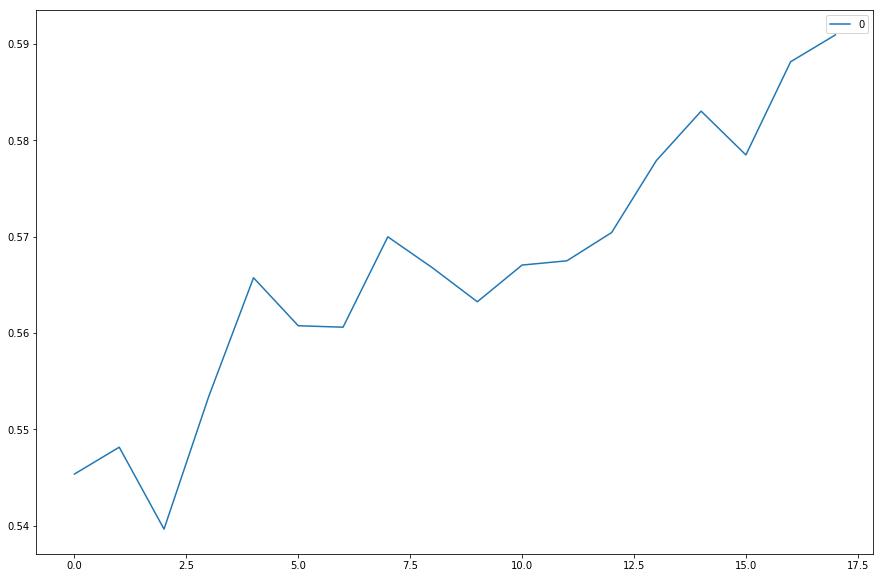

In [49]:
%matplotlib inline
pd.DataFrame(gridSearch.cv_results_['mean_test_score']).plot(figsize=(15,10))

Grid search indicates that below parameters give the best accuracy:

* min_child_weight=10
* max_depth=8
* learning_rate=0.1


## Fit final model

In [8]:
import xgboost as xgb

gbm = xgb.XGBClassifier(
    min_child_weight=10,
    max_depth=8,
    learning_rate=0.1,
    objective = "multi:softprob",
    n_estimators=100,
    eval_metric ="mlogloss",
    n_jobs=2,
    tree_method='gpu_hist',
    n_gpus=1)


gbm.fit(mergedXTrain, YTrain.intention, early_stopping_rounds=10, eval_set=[(mergedXTrain,YTrain.intention)], eval_metric='mlogloss')

[0]	validation_0-mlogloss:3.46496
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:3.22412
[2]	validation_0-mlogloss:3.02691
[3]	validation_0-mlogloss:2.85738
[4]	validation_0-mlogloss:2.71511
[5]	validation_0-mlogloss:2.58455
[6]	validation_0-mlogloss:2.46999
[7]	validation_0-mlogloss:2.36404
[8]	validation_0-mlogloss:2.27037
[9]	validation_0-mlogloss:2.17924
[10]	validation_0-mlogloss:2.094
[11]	validation_0-mlogloss:2.01384
[12]	validation_0-mlogloss:1.93835
[13]	validation_0-mlogloss:1.86735
[14]	validation_0-mlogloss:1.80086
[15]	validation_0-mlogloss:1.73517
[16]	validation_0-mlogloss:1.67494
[17]	validation_0-mlogloss:1.61836
[18]	validation_0-mlogloss:1.5642
[19]	validation_0-mlogloss:1.51314
[20]	validation_0-mlogloss:1.46341
[21]	validation_0-mlogloss:1.41585
[22]	validation_0-mlogloss:1.36998
[23]	validation_0-mlogloss:1.32626
[24]	validation_0-mlogloss:1.28278
[25]	validation_0-mlogloss:1.24258
[26]	validation_0-mlogloss:1.20299

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=100, n_gpus=1,
       n_jobs=2, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [54]:
pd.Series(gbm.feature_importances_).describe()

count    620.000000
mean       0.001613
std        0.001050
min        0.000000
25%        0.001054
50%        0.001342
75%        0.001749
max        0.010161
dtype: float64

In [1]:
gbm.feature_importances_

NameError: name 'gbm' is not defined

In [58]:
YPredicted = gbm.predict(mergedXTest)
YTrue = YTest.intention

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [64]:
# %load ../utils/vizu.py
import matplotlib.pyplot as plt
import itertools

def plot_keras_model_learning_curve(history):
    ''' plot accuracy of the Keras model on training and validation set '''
    plt.figure(figsize=(12,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.93      0.40      0.56        35
          1       0.00      0.00      0.00         4
          2       1.00      0.20      0.33         5
          3       0.00      0.00      0.00         1
          4       0.88      0.64      0.74        11
          5       0.60      0.17      0.26        18
          6       1.00      0.75      0.86         4
          7       0.00      0.00      0.00         1
          8       0.80      0.48      0.60        25
          9       0.20      0.14      0.17         7
         10       0.62      0.42      0.50        12
         11       0.53      0.37      0.43        27
         12       0.38      0.50      0.43         6
         13       0.46      0.50      0.48        12
         14       0.47      0.43      0.45        42
         15       0.57      1.00      0.73         4
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00   

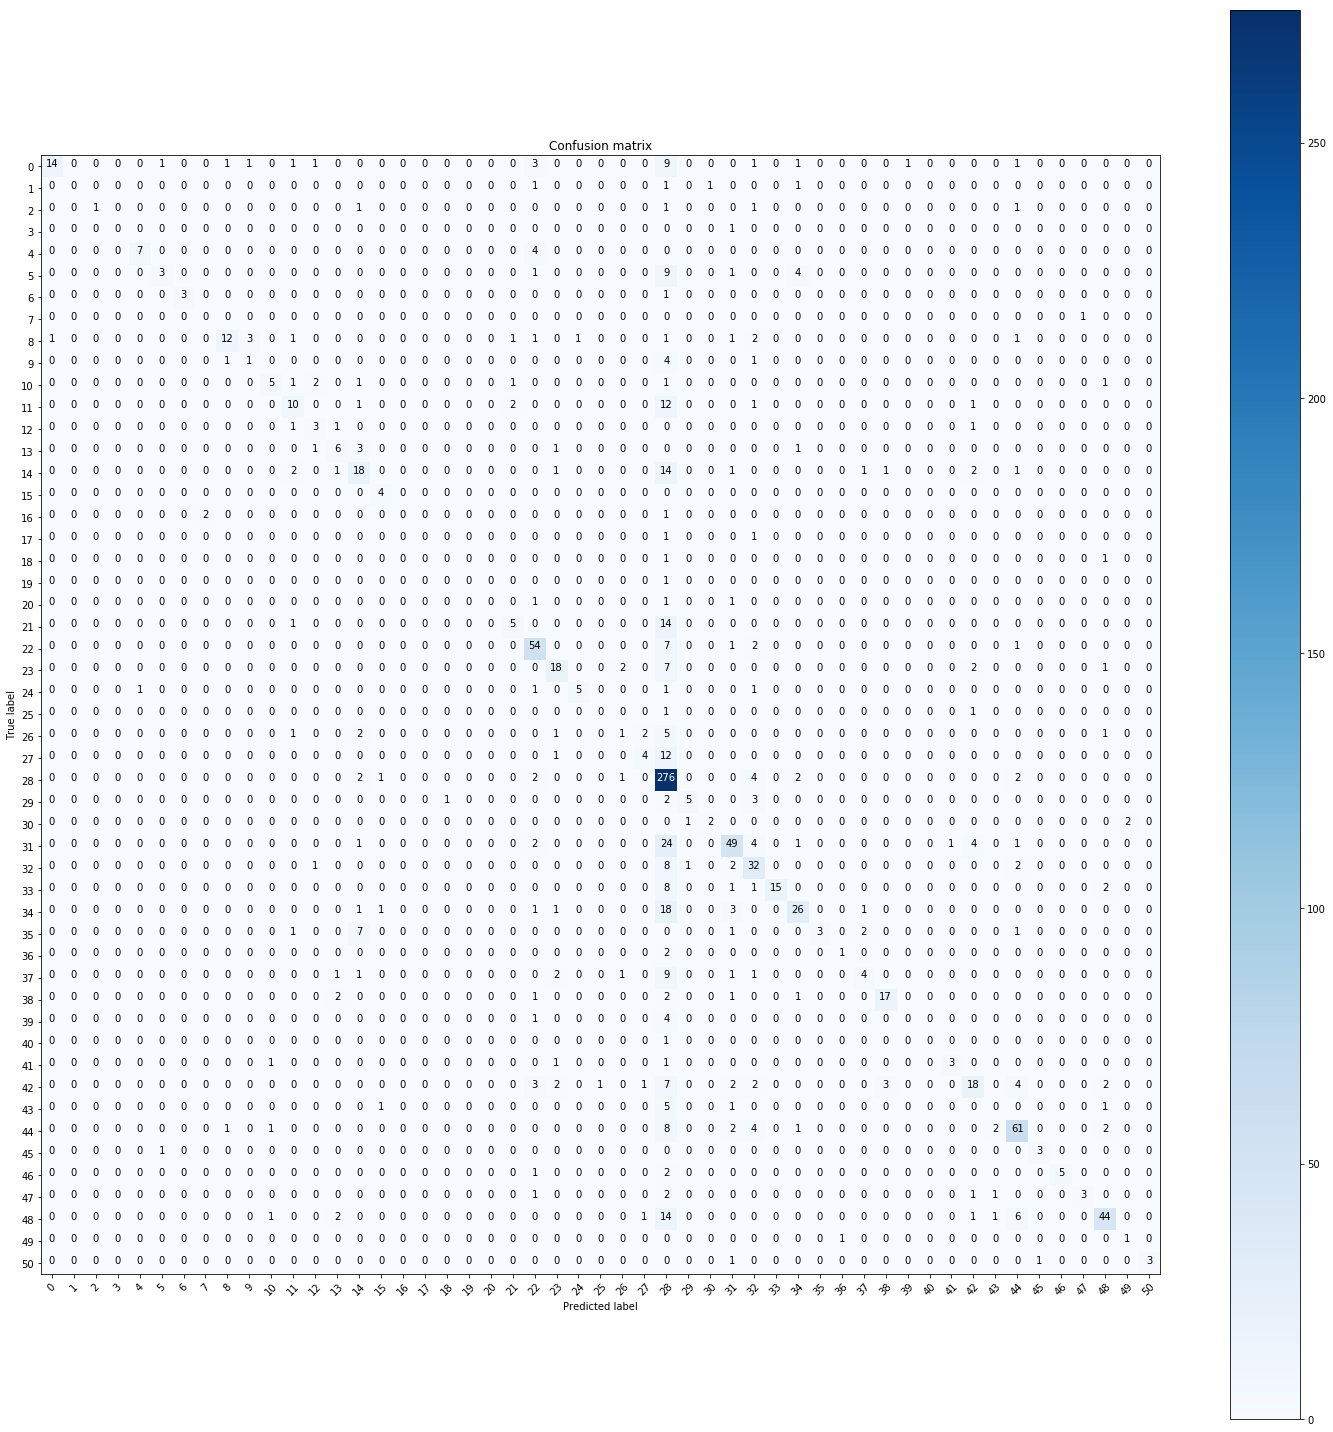

In [65]:
%matplotlib inline

import sklearn
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()
